In [2]:
import glob
import numpy as np

In [3]:
frds = glob.glob('output/ccx/*/*/*.frd')
dats = glob.glob('output/ccx/*/*/*.dat')

In [4]:
frds

['output/ccx\\SX\\E_00\\main.frd',
 'output/ccx\\SX\\E_01\\main.frd',
 'output/ccx\\SX\\E_02\\main.frd',
 'output/ccx\\SX\\E_03\\main.frd',
 'output/ccx\\SX\\E_04\\main.frd',
 'output/ccx\\SX\\E_05\\main.frd',
 'output/ccx\\SX\\E_06\\main.frd',
 'output/ccx\\SX\\E_07\\main.frd',
 'output/ccx\\SX\\E_08\\main.frd',
 'output/ccx\\SX\\E_09\\main.frd',
 'output/ccx\\SX\\E_10\\main.frd',
 'output/ccx\\SX\\E_11\\main.frd',
 'output/ccx\\SX\\E_12\\main.frd',
 'output/ccx\\SX\\E_13\\main.frd',
 'output/ccx\\SX\\E_14\\main.frd',
 'output/ccx\\SX\\E_15\\main.frd']

In [5]:
t_l = 0.475 #  Espesor de la capa [mm]
t_n = 2.934
A_s = 0.30972128894583056 # mm^2

r = 3*t_l/8 
d = (A_s - np.pi*r**2)/(2*r) # Area de la capa [mm^2]
params_composite ={
    "r"         :  r,
    "d"         :  d,
    "h"         :  t_l,
    "z0"        :  0,
    "density"   : 5,
}

params_ccx = {
    "epsilon" : 0.1,
    "x_fixed" : True
}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [6]:
E_Resina =  3.59*1e3 
E_Carbon =  86.75*1e3

params["ccx"]["E_carbon"] = E_Carbon
params["ccx"]["nu"] = 0.3
params["ccx"]["E_resina"] = E_Resina
params["ccx"]["nu_resina"] = 0.3

E_r_linspace = np.linspace(0.5*E_Resina, 1.5*E_Resina, 4)
E_c_linspace = np.linspace(0.5*E_Carbon, 1.5*E_Carbon, 4)

E_r_ms, E_c_ms = np.meshgrid(E_r_linspace, E_c_linspace)

E_pairs = []
for i in range(E_r_ms.shape[0]):
    for j in range(E_r_ms.shape[1]):
        E_pairs.append((E_r_ms[i,j], E_c_ms[i,j]))
E_pairs = np.array(E_pairs)*1e-3 # Convertir a GPa

In [7]:
E_c_linspace*1e-3

array([ 43.375     ,  72.29166667, 101.20833333, 130.125     ])

In [8]:
E_r_linspace*1e-3

array([1.795     , 2.99166667, 4.18833333, 5.385     ])

In [7]:
from djccx.read_dat import read_dat
from djccx.frd.readfrd import readfrd

In [8]:
params

{'mesh': {'r': 0.17812499999999998,
  'd': 0.5895949960674292,
  'h': 0.475,
  'z0': 0,
  'density': 5},
 'ccx': {'epsilon': 0.1,
  'x_fixed': True,
  'E_carbon': 86750.0,
  'nu': 0.3,
  'E_resina': 3590.0,
  'nu_resina': 0.3}}

In [9]:


def compute_E_eff(iffiles):

    largo = 10 
    A = t_l*largo
    try:
        ifrd = readfrd(iffiles)
    except:
        print("Error reading frd file")
        return 0
    df = ifrd["data"]
    Sapl = np.sum(df["F2"]*(df["y"] > df["y"].mean()))/A

    E_eff = Sapl / params["ccx"]["epsilon"]
    return E_eff

E_effs = [compute_E_eff(f) for f in frds]
#E_effs = [compute_E_eff(f,ini) for f,ini in zip(frds[0:1],ni[0:1])]
E_effs = np.array(E_effs)*1e-3

In [10]:
E_Resina

3590.0

In [11]:
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.DataFrame(E_pairs, columns=["E_r", "E_c"])
df["E_eff"] = E_effs

Text(0, 0.5, 'E_eff [GPa]')

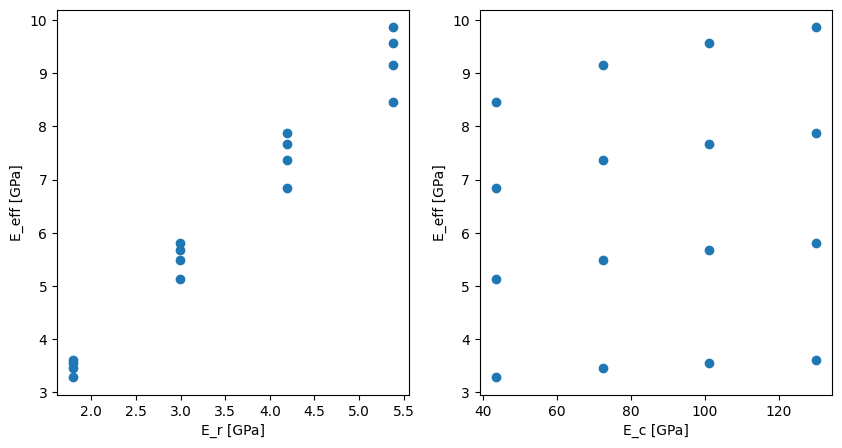

In [12]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(E_pairs[:,0], E_effs, "o", label="E_r")
plt.xlabel("E_r [GPa]")
plt.ylabel("E_eff [GPa]")
# plt.ylim(0.8,1.5)
plt.subplot(122)
plt.plot(E_pairs[:,1], E_effs, "o", label="E_c")
plt.xlabel("E_c [GPa]")
plt.ylabel("E_eff [GPa]")
# plt.ylim(0.8,1.5)


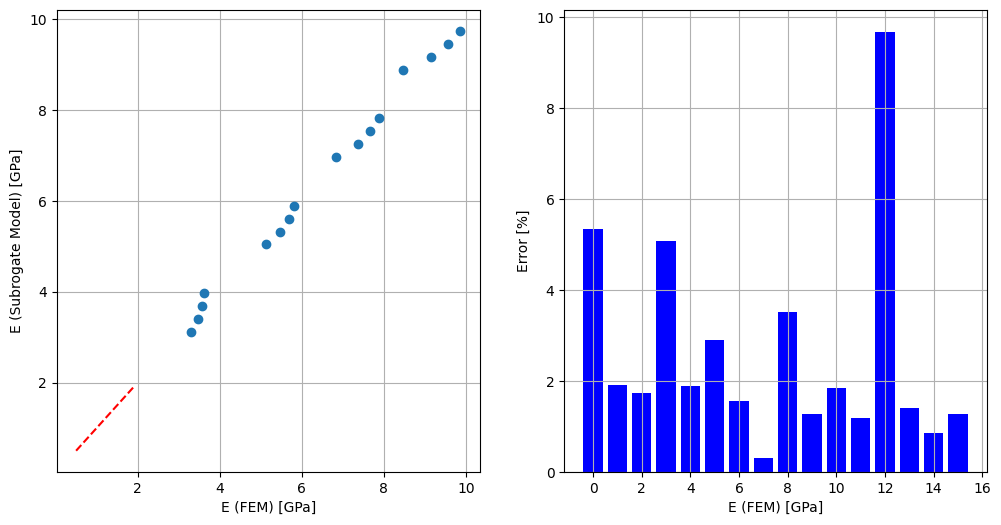

In [13]:
# find the linear regression of E_eff vs E_r,E_c

X = df[["E_r", "E_c"]].values
y = df["E_eff"].values

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X, y)

y_pred = model.predict(X)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(y, y_pred, "o")
plt.xlabel("E (FEM) [GPa]")
plt.ylabel("E (Subrogate Model) [GPa]")
# line 1:1 
plt.plot([0.5, 1.9], [0.5, 1.9], "r--")
plt.grid()
error = np.abs(y - y_pred) / y * 100
plt.subplot(122)
# bar plot 
plt.bar(range(len(error)), error, color="blue")
plt.xlabel("E (FEM) [GPa]")
plt.ylabel("Error [%]")
plt.grid()

Text(0.5, 1.0, 'E_eff (FEM)')

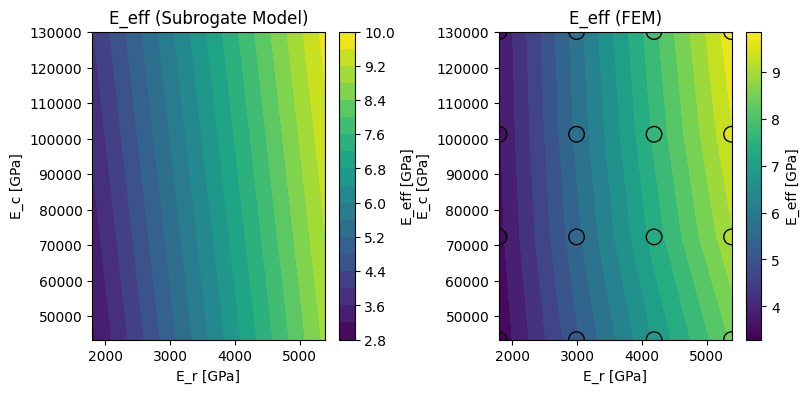

In [14]:
# contour plot 
plt.figure(figsize=(9, 4))
# padding
plt.subplots_adjust(wspace=0.4, hspace=0.4) 
#
plt.subplot(121)
plt.contourf(E_r_ms, E_c_ms, y_pred.reshape(E_r_ms.shape), levels=20)
plt.colorbar(label="E_eff [GPa]")

plt.xlabel("E_r [GPa]")
plt.ylabel("E_c [GPa]")

plt.title("E_eff (Subrogate Model)")

plt.subplot(122)

plt.contourf(E_r_ms, E_c_ms, y.reshape(E_r_ms.shape), levels=20)
# scater plot
plt.scatter(E_r_ms, E_c_ms, c=E_effs, cmap="viridis", marker=".", s=500, edgecolor="k")
plt.colorbar(label="E_eff [GPa]")
plt.xlabel("E_r [GPa]")
plt.ylabel("E_c [GPa]")
plt.title("E_eff (FEM)")


Text(0.5, 0, 'E_eff')

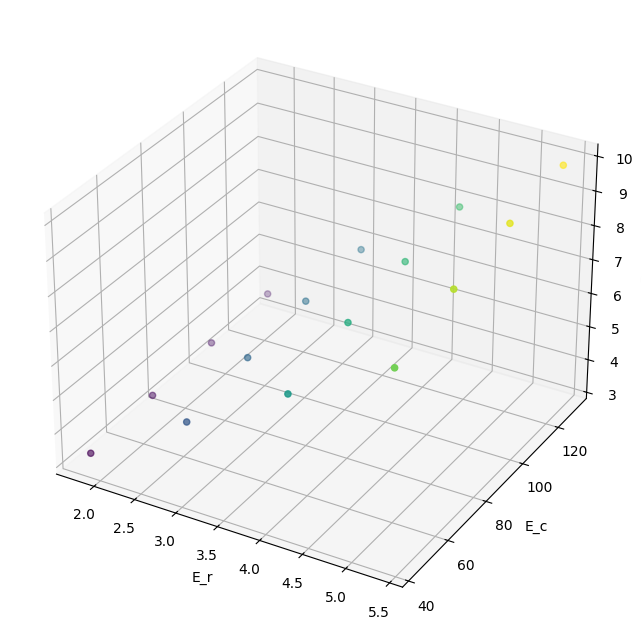

In [15]:
# scater plot


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df["E_r"], df["E_c"], df["E_eff"], c=df["E_eff"], cmap='viridis', marker='o')
ax.set_xlabel('E_r')
ax.set_ylabel('E_c')
ax.set_zlabel('E_eff')

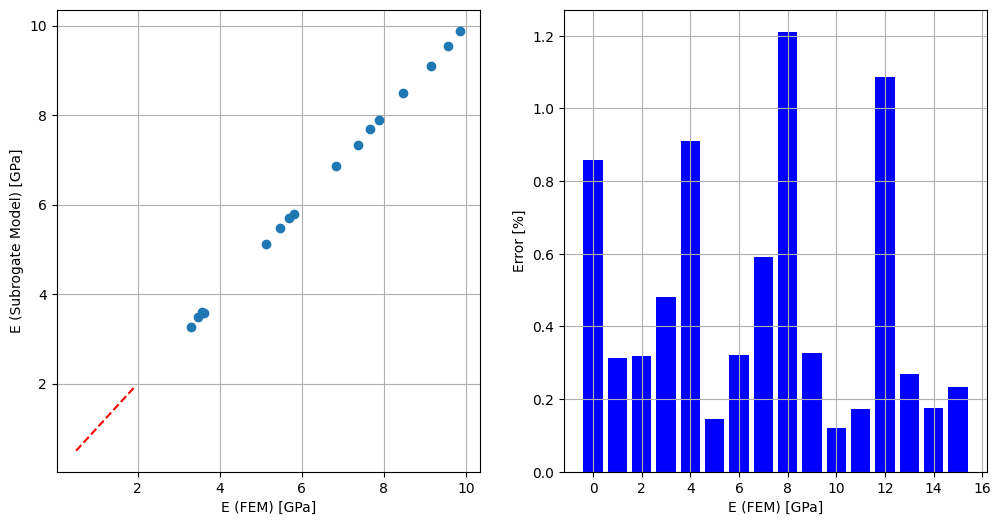

<Figure size 900x400 with 0 Axes>

In [16]:
# cuadratic regression

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2,interaction_only=False)

X_poly = poly.fit_transform(X)

model_poly = LinearRegression()

model_poly.fit(X_poly, y)

y_poly_pred = model_poly.predict(X_poly)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(y, y_poly_pred, "o")
plt.xlabel("E (FEM) [GPa]")
plt.ylabel("E (Subrogate Model) [GPa]")
# line 1:1
plt.plot([0.5, 1.9], [0.5, 1.9], "r--")

plt.grid()

error_poly = np.abs(y - y_poly_pred) / y * 100

plt.subplot(122)

# bar plot

plt.bar(range(len(error_poly)), error_poly, color="blue")

plt.xlabel("E (FEM) [GPa]")

plt.ylabel("Error [%]")

plt.grid()

# contour plot
plt.figure(figsize=(9, 4))
# padding
plt.subplots_adjust(wspace=0.4, hspace=0.4)


In [17]:
# E_r, E_c
poly.get_feature_names_out( input_features=["E_r", "E_c"])

array(['1', 'E_r', 'E_c', 'E_r^2', 'E_r E_c', 'E_c^2'], dtype=object)

In [18]:
# see coefficients of the polynomial regression
model_poly.coef_

array([ 0.00000000e+00,  1.59335813e+00,  1.08027952e-02, -3.95841963e-02,
        3.44920379e-03, -7.68971432e-05])

[ 0.00e+00  1.59e+00  1.08e-02 -3.96e-02  3.45e-03 -7.69e-05]


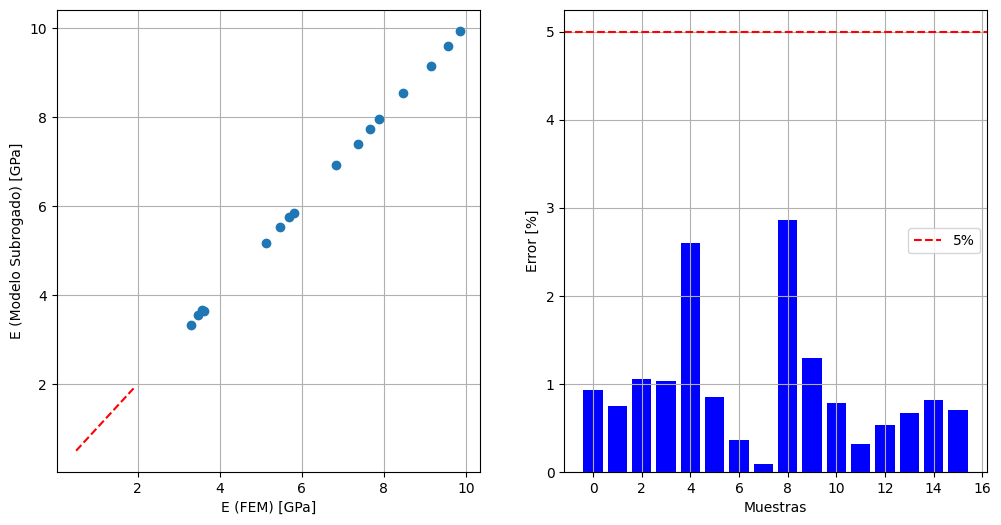

In [19]:

coef = model_poly.coef_
# round 2 significant digits in scientific notation
# float 
coef = np.array([f"{c:.2e}" for c in coef])
coef = coef.astype(float)
print(coef)
def PolyModel(x):
    return coef[0] + \
           coef[1]*x[:,0] + \
           coef[2]*x[:,1] + \
           coef[3]*x[:,0]**2 + \
           coef[4]*x[:,0]*x[:,1] + \
           coef[5]*x[:,1]**2

ypred = PolyModel(X)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(y, ypred, "o")
plt.xlabel("E (FEM) [GPa]")
plt.ylabel("E (Modelo Subrogado) [GPa]")
# line 1:1
plt.plot([0.5, 1.9], [0.5, 1.9], "r--")
plt.grid()

error_poly = np.abs(y - ypred) / y * 100
plt.subplot(122)

# bar plot

plt.bar(range(len(error_poly)), error_poly, color="blue")
plt.xlabel("Muestras")
plt.ylabel("Error [%]")
# horizonal line 
plt.axhline(y=5, color='r', linestyle='--',label="5%")
plt.grid()
plt.legend()


Text(0.5, 0, 'E_eff')

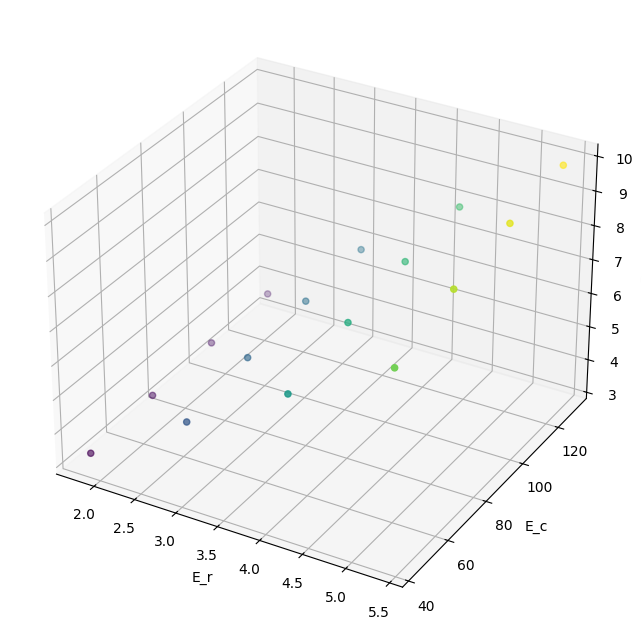

In [20]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df["E_r"], df["E_c"], df["E_eff"], c=df["E_eff"], cmap='viridis', marker='o')
ax.set_xlabel('E_r')
ax.set_ylabel('E_c')
ax.set_zlabel('E_eff')


In [21]:
# que pasa si no usamos E_c^2 


In [22]:
# matematical syntax
model_poly.intercept_

np.float64(-0.06486267489817266)

In [ ]:
# [ 0.00e+00  1.55e-03  1.02e-05 -3.70e-08  3.21e-09 -7.12e-11]
# [ 0.00e+00  1.55e-03  1.02e-05 -3.70e-08  3.21e-09 -7.12e-11]
# [ 0.00e+00  1.55e+00  1.02e-02 -3.70e-02  3.21e-03 -7.12e-05]
# [ 0.00e+00  1.59e+00  1.08e-02 -3.96e-02  3.45e-03 -7.69e-05]
# [ 0.00e+00  1.59e+00  1.08e-02 -3.96e-02  3.45e-03 -7.69e-05]


def modelSX(E_resina, E_carbon):
    return 0.00e+00 + \
           1.59e+00*E_resina + \
           1.08e-02*E_carbon - \
           3.96e-02*E_resina**2 + \
           3.45e-03*E_resina*E_carbon - \
           7.69e-05*E_carbon**2

NameError: name 'E_r_linspace' is not defined